I used the Moving Average Convergence Divergence (MACD) indicator to algorithmically develop buy and sell signals for Facebook and Microsoft 
stocks over the same 11 month time period. MACD is a trend following momentum indicator that is very commonly used.

MACD is calculated using exponential moving averages (EMAs) which are similar to SMAs but gives more weight to current data than historical data. 
MACD = 12 period EMA (short run) - 26 period EMA (long run)
Signal line = 9 period EMA of the MACD

I used the crossover method by buying the stock when MACD crosses above the signal line and selling the stock when the MACD crosses below the signal line. 

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import yfinance
from datetime import date

In [2]:
fb_stock = yfinance.download('FB', start='2020-07-20', end='2021-06-29', interval='1d')
msft_stock = yfinance.download('MSFT', start='2020-07-20', end='2021-06-29', interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
idx = pd.date_range('2020-07-20', '2021-06-29')

In [4]:
msft_stock = msft_stock.reindex(idx, fill_value=np.nan)
fb_stock = fb_stock.reindex(idx, fill_value=np.nan)

In [5]:
msft_stock['Adj Close'] = msft_stock['Adj Close'].ffill().bfill()
fb_stock['Adj Close'] = fb_stock['Adj Close'].ffill().bfill()

In [6]:
fb_short_term_ema = fb_stock['Adj Close'].ewm(span=12, adjust=False).mean()
fb_long_term_ema = fb_stock['Adj Close'].ewm(span=26, adjust=False).mean()
msft_short_term_ema = msft_stock['Adj Close'].ewm(span=12, adjust=False).mean()
msft_long_term_ema = msft_stock['Adj Close'].ewm(span=26, adjust=False).mean()

Make sure there are no null values in the Adj Close column

In [7]:
fb_stock[fb_stock['Adj Close'].isnull().values]
msft_stock[msft_stock['Adj Close'].isnull().values]

,Open,High,Low,Close,Adj Close,Volume


In [8]:
fb_stock['macd'] = fb_short_term_ema - fb_long_term_ema
msft_stock['macd'] = msft_short_term_ema - msft_long_term_ema
fb_stock['signal'] = fb_stock['macd'].ewm(span=9, adjust=False).mean()
msft_stock['signal'] = msft_stock['macd'].ewm(span=9, adjust=False).mean()

In [9]:
fb_stock.head(5)

,Open,High,Low,Close,Adj Close,Volume,macd,signal
2020-07-20,240.059998,246.050003,235.639999,245.419998,245.419998,20872200.0,0.000000,0.000000
2020-07-21,246.220001,246.910004,240.080002,241.750000,241.750000,19364200.0,-0.292763,-0.058553
2020-07-22,240.259995,241.899994,238.119995,239.869995,239.869995,15427900.0,-0.668772,-0.180597
2020-07-23,239.630005,242.419998,231.750000,232.600006,232.600006,21771800.0,-1.535686,-0.451615
2020-07-24,230.190002,233.490005,226.899994,230.710007,230.710007,18325800.0,-2.348161,-0.830924


In [10]:
msft_stock.head(5)

,Open,High,Low,Close,Adj Close,Volume,macd,signal
2020-07-20,205.000000,212.300003,203.009995,211.600006,209.570831,36884800.0,0.000000,0.000000
2020-07-21,213.660004,213.940002,208.029999,208.750000,206.748154,37990400.0,-0.225171,-0.045034
2020-07-22,209.199997,212.300003,208.389999,211.750000,209.719360,49605700.0,-0.162001,-0.068428
2020-07-23,207.190002,210.919998,202.149994,202.539993,200.597687,67457000.0,-0.838318,-0.222406
2020-07-24,200.419998,202.860001,197.509995,201.300003,199.369598,39827000.0,-1.456610,-0.469247


In [11]:
def buy_sell_indicators(df):
    buy_points = []
    sell_points = []
    stock_status = 0
    transaction_history = []
    transaction_history_price = []
    profit = 0
    for index in range(0, len(df)):
        if index != 0 and stock_status != 1 and df['macd'][index] > df['signal'][index] and df['macd'][index - 1] < df['signal'][index - 1]: 
            buy_points.append(df['Adj Close'][index])
            sell_points.append(np.nan)
            profit -= df['Adj Close'][index]
            transaction_history.append('Buy') 
            transaction_history_price.append(df['Adj Close'][index])
            stock_status = 1
        elif index != 0 and stock_status != 0 and stock_status != 2 and df['macd'][index] < df['signal'][index] and df['macd'][index - 1] > df['signal'][index - 1]:
            buy_points.append(np.nan)
            sell_points.append(df['Adj Close'][index])
            profit += df['Adj Close'][index]
            transaction_history.append('Sell') 
            transaction_history_price.append(df['Adj Close'][index])
            stock_status = 2
        else:
            buy_points.append(np.nan)
            sell_points.append(np.nan)
    if transaction_history.count('Buy') > transaction_history.count('Sell'):
        profit += transaction_history_price[-1]
    return buy_points, sell_points, profit

In [12]:
fb_stock['Buy'] = buy_sell_indicators(fb_stock)[0]
fb_stock['Sell'] = buy_sell_indicators(fb_stock)[1]
fb_stock_profit = buy_sell_indicators(fb_stock)[2]
msft_stock['Buy'] = buy_sell_indicators(msft_stock)[0]
msft_stock['Sell'] = buy_sell_indicators(msft_stock)[1]
msft_stock_profit = buy_sell_indicators(msft_stock)[2]

In [13]:
print('The Facebook stock earned a profit of ' + '${:,.2f}'.format(fb_stock_profit) + ' using the MACD')
print('The Microsoft stock earned a profit of ' + '${:,.2f}'.format(msft_stock_profit) + ' using the MACD')

The Facebook stock earned a profit of $-21.89 using the MACD
The Microsoft stock earned a profit of $34.92 using the MACD


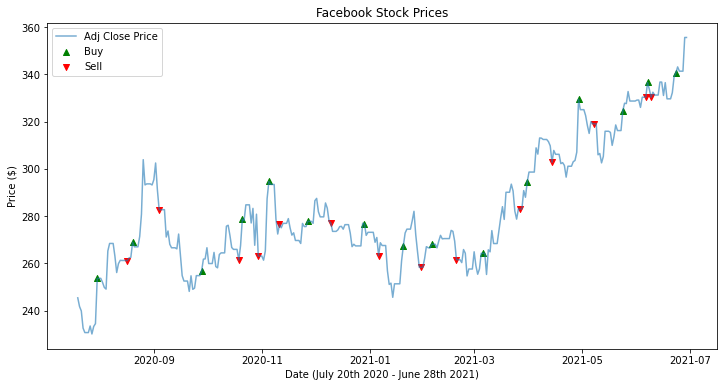

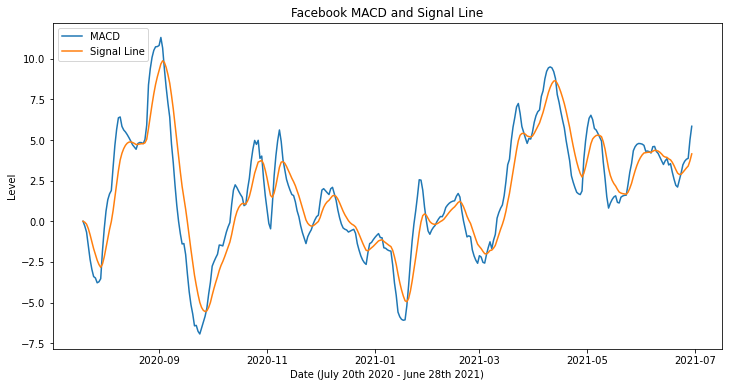

In [14]:
plt.figure(figsize=(12, 6))
plt.title('Facebook Stock Prices')
plt.plot(fb_stock.index, fb_stock['Adj Close'], alpha=0.6)
plt.scatter(fb_stock.index, fb_stock['Buy'], color='green', marker='^')
plt.scatter(fb_stock.index, fb_stock['Sell'], color='red', marker='v')
plt.legend(['Adj Close Price', 'Buy', 'Sell'], loc='upper left')
plt.xlabel('Date (July 20th 2020 - June 28th 2021)')
plt.ylabel('Price ($)')
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Facebook MACD and Signal Line')
plt.plot(fb_stock.index, fb_stock['macd'])
plt.plot(fb_stock.index, fb_stock['signal'])
plt.legend(['MACD', 'Signal Line'], loc='upper left')
plt.xlabel('Date (July 20th 2020 - June 28th 2021)')
plt.ylabel('Level')
#plt.legend(['Adj Close Price', '25d SMA', '100d SMA', 'Buy', 'Sell'], loc='upper left')
plt.show()

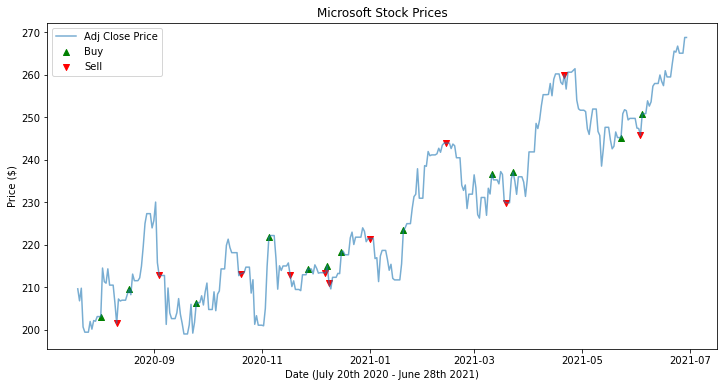

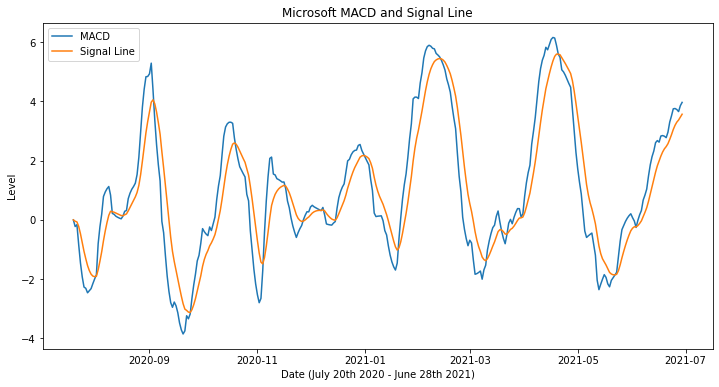

In [15]:
plt.figure(figsize=(12, 6))
plt.title('Microsoft Stock Prices')
plt.plot(msft_stock.index, msft_stock['Adj Close'], alpha=0.6)
plt.scatter(msft_stock.index, msft_stock['Buy'], color='green', marker='^')
plt.scatter(msft_stock.index, msft_stock['Sell'], color='red', marker='v')
plt.legend(['Adj Close Price', 'Buy', 'Sell'], loc='upper left')
plt.xlabel('Date (July 20th 2020 - June 28th 2021)')
plt.ylabel('Price ($)')
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Microsoft MACD and Signal Line')
plt.plot(msft_stock.index, msft_stock['macd'])
plt.plot(msft_stock.index, msft_stock['signal'])
plt.legend(['MACD', 'Signal Line'], loc='upper left')
plt.xlabel('Date (July 20th 2020 - June 28th 2021)')
plt.ylabel('Level')
#plt.legend(['Adj Close Price', '25d SMA', '100d SMA', 'Buy', 'Sell'], loc='upper left')
plt.show()